<a href="https://colab.research.google.com/github/kevinrchilders/computer-vision/blob/master/regularization_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of regularization techniques for image classification

We will use a dataset consisting of a few thousand pictuers of 5 types of flowers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation

In [3]:
# Download the dataset and split into training and validation sets

(train_ds, val_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


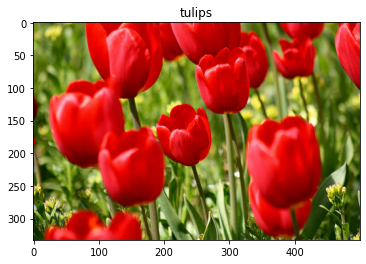

In [5]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [6]:
# Set some basic parameters

batch_size = 32
img_height = 180
img_width = 180
num_epochs=30

In [7]:
# The images have different sizes, so resize to (img_height, img_weight) and rescale by 1/255

train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, (img_height, img_width))/255, label))
val_ds = val_ds.map(lambda image, label: (tf.image.resize(image, (img_height, img_width))/255, label))

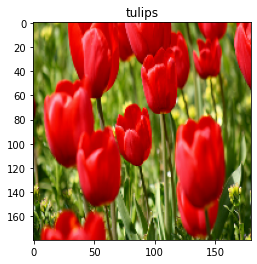

In [8]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [9]:
# Batch data, etc.

train_ds = train_ds.cache().shuffle(1000).batch(batch_size).prefetch(1)
val_ds = val_ds.cache().shuffle(1000).batch(batch_size).prefetch(1)

---

## A basic unregularized CNN

We will start with a simple CNN.

In [10]:
unreg_model = Sequential([
                          Conv2D(16, 3, activation='relu', input_shape=(img_height, img_width, 3)),
                          MaxPooling2D(),
                          Conv2D(16, 3, activation='relu'),
                          MaxPooling2D(),
                          Conv2D(32, 3, activation='relu'),
                          MaxPooling2D(),
                          Conv2D(32, 3, activation='relu'),
                          MaxPooling2D(),
                          Flatten(),
                          Dense(64, activation='relu'),
                          Dense(num_classes)
])

unreg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 32)        9

In [11]:
unreg_model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [12]:
history = unreg_model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

Epoch 1/30
92/92 [==============================] - 7s 76ms/step - loss: 1.3171 - accuracy: 0.4091 - val_loss: 1.1783 - val_accuracy: 0.4714
Epoch 2/30
92/92 [==============================] - 3s 31ms/step - loss: 1.1059 - accuracy: 0.5371 - val_loss: 1.0366 - val_accuracy: 0.5804
Epoch 3/30
92/92 [==============================] - 3s 31ms/step - loss: 0.9942 - accuracy: 0.6012 - val_loss: 0.9519 - val_accuracy: 0.6267
Epoch 4/30
92/92 [==============================] - 3s 31ms/step - loss: 0.8959 - accuracy: 0.6458 - val_loss: 0.9309 - val_accuracy: 0.6226
Epoch 5/30
92/92 [==============================] - 3s 30ms/step - loss: 0.8376 - accuracy: 0.6727 - val_loss: 0.8556 - val_accuracy: 0.6662
Epoch 6/30
92/92 [==============================] - 3s 31ms/step - loss: 0.7269 - accuracy: 0.7200 - val_loss: 0.8024 - val_accuracy: 0.6853
Epoch 7/30
92/92 [==============================] - 3s 31ms/step - loss: 0.6579 - accuracy: 0.7503 - val_loss: 0.8014 - val_accuracy: 0.7057
Epoch 8/30
92

We can see that the model quickly learns the training set, but struggles to continue improving on the validation set.  This is known as high variance or overfitting, and the goal of regularization is to reduce the variance.

---

## L2 Regularization

A basic form of regularization in any machine learning is l2 regularization, which penalizes large parameters using the l2 (Euclidean) norm.

In [13]:
l2reg_model = Sequential([
                          Conv2D(64, 3, activation='relu', input_shape=(img_height, img_width, 3)),
                          MaxPooling2D(),
                          Conv2D(32, 3, activation='relu'),
                          MaxPooling2D(),
                          Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                          MaxPooling2D(),
                          Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                          MaxPooling2D(),
                          Flatten(),
                          Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                          Dense(num_classes)
])

In [14]:
l2reg_model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [15]:
history = l2reg_model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

Epoch 1/30
92/92 [==============================] - 7s 76ms/step - loss: 1.9191 - accuracy: 0.4189 - val_loss: 1.4354 - val_accuracy: 0.4905
Epoch 2/30
92/92 [==============================] - 6s 66ms/step - loss: 1.3383 - accuracy: 0.5300 - val_loss: 1.2802 - val_accuracy: 0.5354
Epoch 3/30
92/92 [==============================] - 6s 67ms/step - loss: 1.2057 - accuracy: 0.5787 - val_loss: 1.2353 - val_accuracy: 0.5763
Epoch 4/30
92/92 [==============================] - 6s 68ms/step - loss: 1.1654 - accuracy: 0.5957 - val_loss: 1.1224 - val_accuracy: 0.5995
Epoch 5/30
92/92 [==============================] - 6s 68ms/step - loss: 1.0918 - accuracy: 0.6294 - val_loss: 1.0881 - val_accuracy: 0.6199
Epoch 6/30
92/92 [==============================] - 6s 68ms/step - loss: 1.0660 - accuracy: 0.6362 - val_loss: 1.0750 - val_accuracy: 0.6199
Epoch 7/30
92/92 [==============================] - 6s 67ms/step - loss: 1.0427 - accuracy: 0.6488 - val_loss: 1.0749 - val_accuracy: 0.6308
Epoch 8/30
92

Note how much learning has slowed.
We spent nearly twice as much time training per epoch, and the accuracy on the training set increased much more slowly per epoch.
In the end, we aren't improving much on the validation set either.
For this particular problem, perhaps L2-regularization isn't the way to go.

---

## Dropout regularization

Dropout regularization is more specific to neural networks.
Instead of using all neurons when training, we randomly "drop" some percentage of the neurons in some layers, so that the network learns not to rely on certain neurons more than others.

In [16]:
dropreg_model = Sequential([
                          Conv2D(16, 3, activation='relu', input_shape=(img_height, img_width, 3)),
                          MaxPooling2D(),
                          Conv2D(16, 3, activation='relu'),
                          MaxPooling2D(),
                          Conv2D(32, 3, activation='relu'),
                          MaxPooling2D(),
                          Dropout(0.5),
                          Conv2D(32, 3, activation='relu'),
                          MaxPooling2D(),
                          Dropout(0.5),
                          Flatten(),
                          Dense(64, activation='relu'),
                          Dropout(0.5),
                          Dense(num_classes)
])

In [17]:
dropreg_model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [18]:
history = dropreg_model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

Epoch 1/30
92/92 [==============================] - 3s 32ms/step - loss: 1.5709 - accuracy: 0.2629 - val_loss: 1.5275 - val_accuracy: 0.2861
Epoch 2/30
92/92 [==============================] - 3s 31ms/step - loss: 1.3729 - accuracy: 0.3896 - val_loss: 1.1831 - val_accuracy: 0.4918
Epoch 3/30
92/92 [==============================] - 3s 31ms/step - loss: 1.2069 - accuracy: 0.4860 - val_loss: 1.0872 - val_accuracy: 0.5845
Epoch 4/30
92/92 [==============================] - 3s 31ms/step - loss: 1.1418 - accuracy: 0.5259 - val_loss: 1.0438 - val_accuracy: 0.5654
Epoch 5/30
92/92 [==============================] - 3s 31ms/step - loss: 1.0810 - accuracy: 0.5599 - val_loss: 0.9885 - val_accuracy: 0.6117
Epoch 6/30
92/92 [==============================] - 3s 31ms/step - loss: 1.0277 - accuracy: 0.5920 - val_loss: 0.9256 - val_accuracy: 0.6226
Epoch 7/30
92/92 [==============================] - 3s 31ms/step - loss: 0.9964 - accuracy: 0.6165 - val_loss: 0.8844 - val_accuracy: 0.6485
Epoch 8/30
92

We can see that the training time per epoch is much better than for L2 regularization, and we've been able to improve much more on the validation accuracy.
While learning has slowed down (training set accuracy), the variance has remained low through 30 epochs.
Dropout looks very promising for our problem!

---

## Image augmentation

One of the problems with our dataset is that we have a relatively small dataset for our complex task.  If feasible, getting more data will almost always impove performance.  A cheap way to manufacture more data is to augment the images we do have, by shifting, rotating, reflecting, zooming, etc.

In [19]:
aug_model = Sequential([
                        RandomFlip(mode='horizontal'),
                        RandomTranslation(0.2, 0.2, fill_mode='constant'),
                        RandomRotation(0.2, fill_mode='constant'),
                        RandomZoom(0.2, fill_mode='constant'),
                        Conv2D(64, 3, activation='relu', input_shape=(img_height, img_width, 3)),
                        MaxPooling2D(),
                        Conv2D(32, 3, activation='relu'),
                        MaxPooling2D(),
                        Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                        MaxPooling2D(),
                        Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                        MaxPooling2D(),
                        Flatten(),
                        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                        Dense(num_classes)
])

In [20]:
aug_model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [21]:
aug_model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

Epoch 1/30
92/92 [==============================] - 8s 82ms/step - loss: 1.9990 - accuracy: 0.3869 - val_loss: 1.5078 - val_accuracy: 0.4210
Epoch 2/30
92/92 [==============================] - 7s 81ms/step - loss: 1.4085 - accuracy: 0.4680 - val_loss: 1.2852 - val_accuracy: 0.5286
Epoch 3/30
92/92 [==============================] - 7s 81ms/step - loss: 1.2800 - accuracy: 0.5048 - val_loss: 1.2162 - val_accuracy: 0.5313
Epoch 4/30
92/92 [==============================] - 7s 80ms/step - loss: 1.2555 - accuracy: 0.5221 - val_loss: 1.2086 - val_accuracy: 0.5245
Epoch 5/30
92/92 [==============================] - 7s 80ms/step - loss: 1.1912 - accuracy: 0.5364 - val_loss: 1.1320 - val_accuracy: 0.5722
Epoch 6/30
92/92 [==============================] - 7s 80ms/step - loss: 1.1792 - accuracy: 0.5463 - val_loss: 1.1250 - val_accuracy: 0.5477
Epoch 7/30
92/92 [==============================] - 7s 81ms/step - loss: 1.1491 - accuracy: 0.5634 - val_loss: 1.0878 - val_accuracy: 0.5736
Epoch 8/30
92

Learning has slowed way down, but our model is seeing a much greater variety of images.
Notice that perfomance on the validation set is typically as good or better than the performance on the training set (the random transformations aren't applied on validation).
In the long run, image augmentation is likely to pay off.